In [1]:
%matplotlib inline  

import sys
import itertools
import petl as etl
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

def gMedian(results, field='timeStamp'):
    results = etl.convert(results, field, lambda t: (t - t%60000)/1000)
    results = etl.transform.reductions.aggregate(results, field, lambda e: np.median(map(lambda a: a[1], e)))
    return etl.convert(results, field, datetime.fromtimestamp)


def gMean(results, field='timeStamp'):
    results = etl.convert(results, field, lambda t: (t - t%60000)/1000)
    results = etl.transform.reductions.aggregate(results, field, lambda e: np.mean(map(lambda a: a[1], e)))
    return etl.convert(results, field, datetime.fromtimestamp)

def gCount(results):
    results = etl.convert(results, 'timeStamp', lambda t: (t - t%60000)/1000)
    results = etl.transform.reductions.aggregate(results, 'timeStamp', len)
    results = etl.convert(results, 'value', lambda t: float(t)/60)
    return etl.convert(results, 'timeStamp', datetime.fromtimestamp)

def gCountThreads(results):
    results = etl.convert(results, 'timeStamp', lambda t: (t - t%60000)/1000)
    results = etl.transform.reductions.aggregate(results, 'timeStamp', len)
    return etl.convert(results, 'timeStamp', datetime.fromtimestamp)

def jmeterResults(filename):
    results = etl.fromcsv(filename)
    results = etl.convert(results, 'timeStamp', lambda t: int(t))
    results = etl.convert(results, 'elapsed', lambda t: int(t))
    return results

def cpuResults(filename):
    results = etl.fromcsv(filename)
    results = etl.convert(results, 'date', lambda t: int(t))
    results = etl.convert(results, 'user', lambda t: float(t))
    return results

In [2]:
##GLobal settings
resultsFolder = "demo"
jmeter = jmeterResults(''.join(["/home/runner/performance/", resultsFolder, "/notebook/transactions.csv"]))

jmeterSuccess = etl.select(jmeter, '{success} == "true"')
jmeterFailure = etl.select(jmeter, '{success} == "false"')

In [3]:
rps = gCount(jmeter)

lTime = rps.columns()['timeStamp']
lValue = rps.columns()['value']

maps = {}
maps['timeStamp'] = lambda e: e['timeStamp'] + e['elapsed']
endingSuccess = etl.fieldmap(jmeterSuccess, maps)
endingFailure = etl.fieldmap(jmeterFailure, maps)

tpsSuccess = gCount(endingSuccess)

tSTime = tpsSuccess.columns()['timeStamp']
tSValue = tpsSuccess.columns()['value']

tpsFailure = gCount(endingFailure)

tFTime = tpsFailure.columns()['timeStamp']
tFValue = tpsFailure.columns()['value']

responses = gMean(jmeterSuccess)

rTime = responses.columns()['timeStamp']
rValue = map(lambda e: e, responses.columns()['value'])

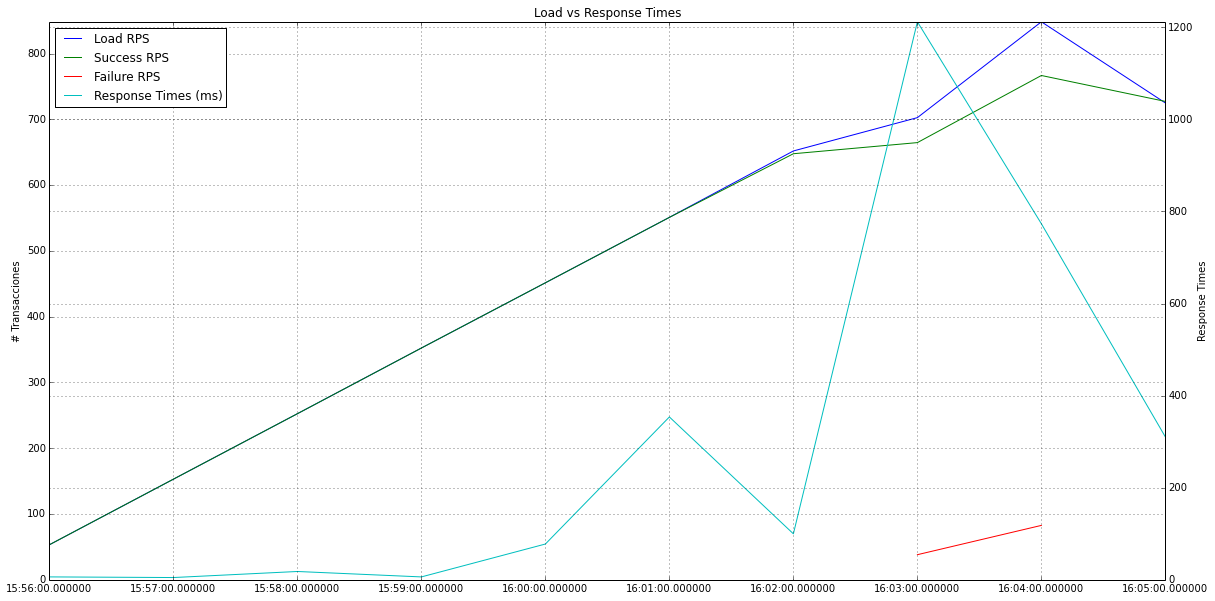

In [4]:
plt.title('Load vs Response Times')

#maxTime = 1000
maxTime = max(rValue[1:])

scale = maxTime/max(lValue[1:])

ax = plt.subplot(111)
ax.plot(lTime[1:], lValue[1:], label='Load RPS')
ax.plot(tSTime[1:], tSValue[1:], label='Success RPS')
ax.plot(tFTime[1:], tFValue[1:], label='Failure RPS')
ax.plot(rTime[1:],  map(lambda e: e/scale, rValue[1:]), label='Response Times (ms)')
ax.set_ylim(0, max(lValue[1:]))
ax.set_ylabel('# Transacciones')
ax.legend()

ax1 = ax.twinx()
ax1.set_ylabel('Response Times')
ax1.set_ylim(0, maxTime)

#ax.set_xlim(datetime.fromtimestamp(1461333848799/1000), datetime.fromtimestamp(1461350048799/1000))
plt.xlabel('Time (s)')

ax.legend(loc="best")

ax.grid()
ax1.grid()

plt.gcf().set_size_inches(20, 10)

plt.show()

In [5]:
jmeter = jmeterResults(''.join(["/home/runner/performance/", resultsFolder, "/notebook/transactions.csv"]))

In [6]:
rps = gCountThreads(jmeter)

lTime = rps.columns()['timeStamp']
lValue = rps.columns()['value']

maps = {}
maps['timeStamp'] = lambda e: e['timeStamp'] + e['elapsed']
ending = etl.fieldmap(jmeter, maps)

tps = gCountThreads(ending)

tTime = tps.columns()['timeStamp']
tValue = tps.columns()['value']

users = map(lambda e: (e[1] - e[0]), zip(np.cumsum(tValue[1:]), np.cumsum(lValue[1:])))

lValue = map(lambda e: float(e)/60, lValue[1:])
tValue = map(lambda e: float(e)/60, tValue[1:])

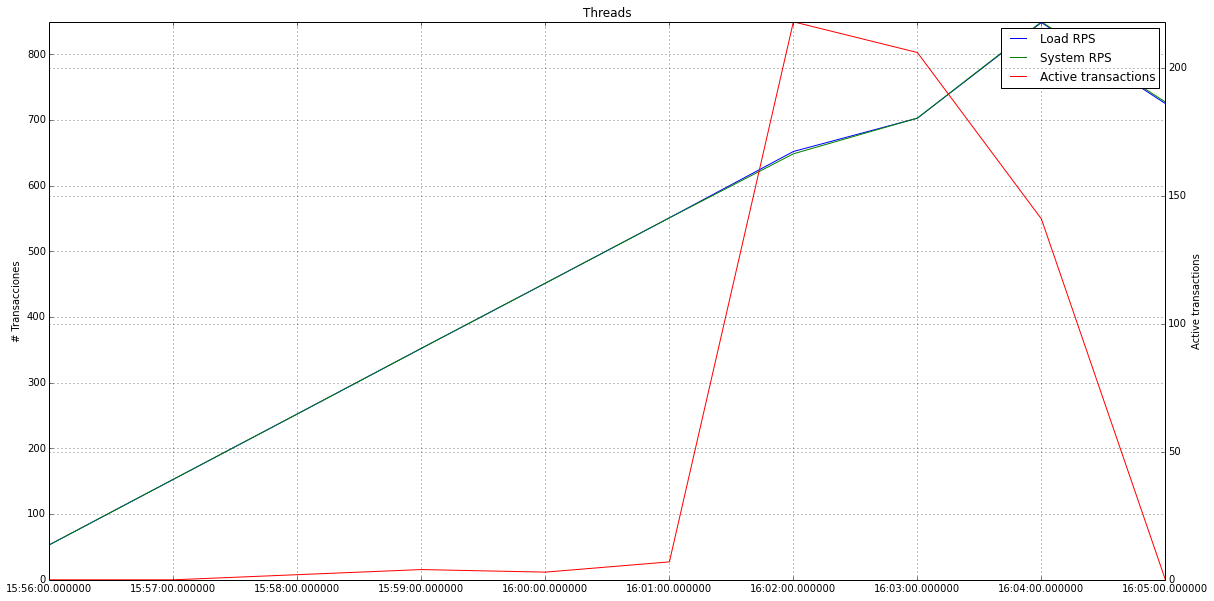

In [7]:
plt.title('Threads')

scale = float(max(users))/max(tValue)

ax = plt.subplot(111)
ax.plot(lTime[1:], lValue, label='Load RPS')
ax.plot(tTime[1:], tValue, label='System RPS')
ax.plot(lTime[1:], map(lambda e: e/scale, users), label='Active transactions')

ax.set_ylim(0, max(tValue))
ax.set_ylabel('# Transacciones')
ax.legend()

ax1 = ax.twinx()
ax1.set_ylabel('Active transactions')
ax1.set_ylim(0, max(users))

plt.xlabel('Time (s)')


ax.grid()
ax1.grid()
plt.gcf().set_size_inches(20, 10)

#ax.set_xlim(datetime.fromtimestamp(1461333848799/1000), datetime.fromtimestamp(1461350048799/1000))

plt.show()